In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PowerTransformer
import lightgbm as lgb
import shap
import optuna
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder

d:\anaconda\envs\env_v3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../../data/processed/mockup_dataset_road_v2.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.head()

,address_subdivision,address_locality,address_line_2,h_id,price_per_m2,land_area,price,longitude,latitude,near_Koh_Pich_in_km,...,f_steps,f_tertiary,f_track,f_trunk,f_trunk_link,f_unclassified,f_unused,index_right,population,polygon_geom
0,Phnom Penh,Chbar Ampov,Preaek Pra,8865846a59fffff,365.99,66,163119.66,104.967388,11.513522,5,...,1,1,1,1,1,1,0,53949.0,102.0,MULTIPOLYGON (((104.96916621116917 11.51342581...
1,Phnom Penh,Chamkar Mon,Tonle Basak,8865846ae1fffff,6573.84,80,178789.60,104.927932,11.557310,1,...,1,1,1,1,1,1,0,53898.0,20064.0,MULTIPOLYGON (((104.93246612049488 11.55646665...
2,Phnom Penh,Mean Chey,Stueng Mean Chey,8865846ad1fffff,3170.62,44,104971.68,104.901617,11.530884,4,...,1,1,1,1,1,1,0,53905.0,16637.0,MULTIPOLYGON (((104.9021486538831 11.528286577...
3,Phnom Penh,Pur SenChey,Chaom Chau,88658461a1fffff,2138.94,32,64163.20,104.877972,11.529098,7,...,1,1,1,1,1,1,0,54661.0,16670.0,MULTIPOLYGON (((104.8840600334987 11.530179322...
4,Phnom Penh,Mean Chey,Boeng Tumpun,8865846ad5fffff,2665.02,40,41927.60,104.905288,11.536313,4,...,1,1,1,1,1,1,0,53903.0,26582.0,MULTIPOLYGON (((104.90746704372549 11.53556911...


In [5]:
# cols = ['price', 'geometry', 'index_right', 'ADM1_EN', 'polygon_geom']
# df.drop(columns=cols, inplace=True)

In [6]:
grouped = df.groupby('h_id')['price_per_m2']
df['h_id_price_mean'] = df['h_id'].map(grouped.mean())
df['h_id_price_max'] = df['h_id'].map(grouped.max())
df['h_id_price_median'] = df['h_id'].map(grouped.median())
df['h_id_price_min'] = df['h_id'].map(grouped.min())

In [7]:
df.to_csv('../../../data/processed/mockup_dataset_road_min_max.csv')

In [8]:
df

,address_subdivision,address_locality,address_line_2,h_id,price_per_m2,land_area,price,longitude,latitude,near_Koh_Pich_in_km,...,f_trunk_link,f_unclassified,f_unused,index_right,population,polygon_geom,h_id_price_mean,h_id_price_max,h_id_price_median,h_id_price_min
0,Phnom Penh,Chbar Ampov,Preaek Pra,8865846a59fffff,365.99,66,163119.66,104.967388,11.513522,5,...,1,1,0,53949.0,102.0,MULTIPOLYGON (((104.96916621116917 11.51342581...,667.03025,994.10,619.205,357.62
1,Phnom Penh,Chamkar Mon,Tonle Basak,8865846ae1fffff,6573.84,80,178789.60,104.927932,11.557310,1,...,1,1,0,53898.0,20064.0,MULTIPOLYGON (((104.93246612049488 11.55646665...,6632.42350,8387.33,6735.895,3666.68
2,Phnom Penh,Mean Chey,Stueng Mean Chey,8865846ad1fffff,3170.62,44,104971.68,104.901617,11.530884,4,...,1,1,0,53905.0,16637.0,MULTIPOLYGON (((104.9021486538831 11.528286577...,2603.92775,3252.43,2711.260,1565.85
3,Phnom Penh,Pur SenChey,Chaom Chau,88658461a1fffff,2138.94,32,64163.20,104.877972,11.529098,7,...,1,1,0,54661.0,16670.0,MULTIPOLYGON (((104.8840600334987 11.530179322...,1984.85375,2570.38,1941.835,1601.71
4,Phnom Penh,Mean Chey,Boeng Tumpun,8865846ad5fffff,2665.02,40,41927.60,104.905288,11.536313,4,...,1,1,0,53903.0,26582.0,MULTIPOLYGON (((104.90746704372549 11.53556911...,3157.24475,3804.27,3258.825,2516.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Phnom Penh,Chraoy Chongvar,Preaek Lieb,88658469d5fffff,1086.59,60,237993.00,104.913136,11.643104,10,...,1,1,0,54000.0,2956.0,MULTIPOLYGON (((104.91862217881888 11.64414172...,1192.46725,1323.00,1189.050,1086.59
9996,Phnom Penh,Dangkao,Cheung Aek,8865846067fffff,299.05,44,71154.16,104.917383,11.461337,10,...,1,1,0,54778.0,391.0,MULTIPOLYGON (((104.91758632719745 11.45611603...,295.05150,360.57,290.100,242.18
9997,Phnom Penh,Chraoy Chongvar,Bak Kaeng,886586a691fffff,414.87,40,29394.00,104.929070,11.704599,17,...,1,1,0,38898.0,627.0,MULTIPOLYGON (((104.93404706256203 11.70522358...,353.67975,465.17,343.300,282.20
9998,Phnom Penh,Dangkao,Preaek Kampues,8865846005fffff,235.31,82,28037.44,104.901623,11.455297,11,...,1,1,0,54821.0,878.0,MULTIPOLYGON (((104.90322795530635 11.44977723...,230.69250,252.03,231.455,210.09


In [9]:
X = df.drop(['price_per_m2','longitude','latitude','address_subdivision','h_id', 'address_locality', 'price', 'geometry', 'polygon_geom', 'index_right'], axis=1, errors='ignore')
y = df['price_per_m2']

In [10]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
cat_cols

Index(['address_line_2'], dtype='object')

In [11]:
# Temporarily encode categorical columns for feature selection
X_temp = X.copy()
if len(cat_cols) > 0:
    encoder = OrdinalEncoder()
    X_temp[cat_cols] = encoder.fit_transform(X_temp[cat_cols])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42)

In [13]:
model = GradientBoostingRegressor(random_state=42)

# Recursive Feature Elimination
selector = RFE(model, n_features_to_select=20, step=1)
selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]

In [14]:
print("Selected features:", selected_features.tolist())

Selected features: ['address_line_2', 'near_Koh_Pich_in_km', 'near_Boeng_Keng_Kang_1_in_km', 'n_cafe_5km', 'n_hospital_in_1km_to_2km', 'nearest_hotel', 'n_hotel_in_3km_to_5km', 'n_pre_school_in_1km_to_2km', 'n_primary_school_in_3km_to_5km', 'n_university_5km', 'n_resturant_in_1km', 'n_super_market_in_1km', 'n_super_market_in_1km_to_2km', 'n_super_market_in_2km_to_3km', 'n_super_market_in_3km_to_5km', 'nearest_atm', 'n_atm_in_1km', 'h_id_price_mean', 'h_id_price_max', 'h_id_price_median']


In [15]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

In [16]:
# 5. Hyperparameter Tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train_sel, y_train)
    
    score = model.score(X_test_sel, y_test)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-06-30 13:38:36,296] A new study created in memory with name: no-name-f7b4d20d-f6a3-4e58-a455-2452472c9d0a


[I 2025-06-30 13:38:50,377] Trial 0 finished with value: 0.9564297672992522 and parameters: {'n_estimators': 1724, 'learning_rate': 0.01315328320801403, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 8, 'subsample': 0.7177466274391684, 'max_features': 'log2'}. Best is trial 0 with value: 0.9564297672992522.
[I 2025-06-30 13:38:59,874] Trial 1 finished with value: 0.9576616620857058 and parameters: {'n_estimators': 750, 'learning_rate': 0.013868775517389954, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.6976931601130487, 'max_features': 'log2'}. Best is trial 1 with value: 0.9576616620857058.
[I 2025-06-30 13:39:10,419] Trial 2 finished with value: 0.9628952270682781 and parameters: {'n_estimators': 1106, 'learning_rate': 0.06594035826596394, 'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 6, 'subsample': 0.640698259477055, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.9628952270682781.
[I 2025-06-30 13:39:29,966] Trial

Best parameters: {'n_estimators': 568, 'learning_rate': 0.08900614072050447, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 10, 'subsample': 0.9957691337576864, 'max_features': None}


In [17]:

# 6. Train Final Model
final_model = GradientBoostingRegressor(**best_params)
final_model.fit(X_train_sel, y_train)

GradientBoostingRegressor(learning_rate=0.08900614072050447, max_depth=6,
                          min_samples_leaf=10, min_samples_split=9,
                          n_estimators=568, subsample=0.9957691337576864)

C:\Users\User\AppData\Local\Temp\ipykernel_27956\645437287.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


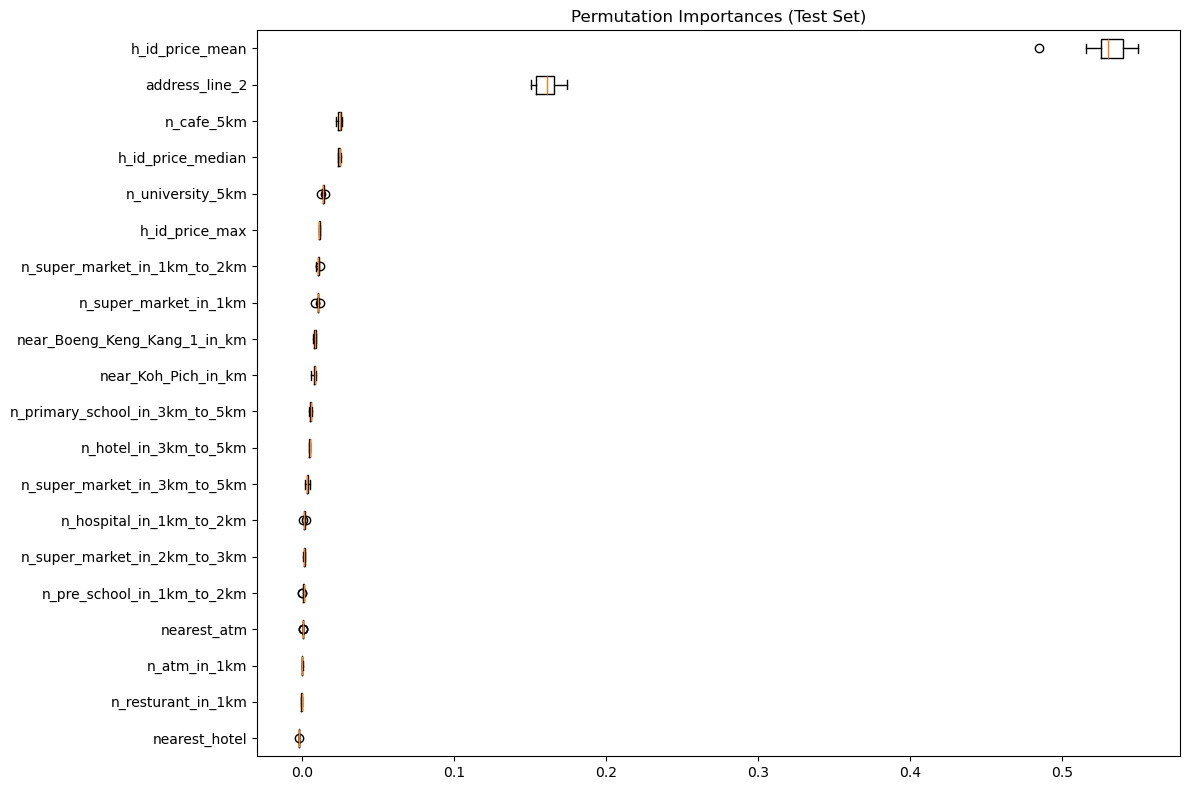

In [18]:
# 7. Evaluate Feature Importance
# Permutation importance
result = permutation_importance(
    final_model, 
    X_test_sel, 
    y_test, 
    n_repeats=10,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X_test_sel.columns[sorted_idx]
)
plt.title("Permutation Importances (Test Set)")
plt.tight_layout()
plt.savefig("permutation_importance.png")
plt.show()


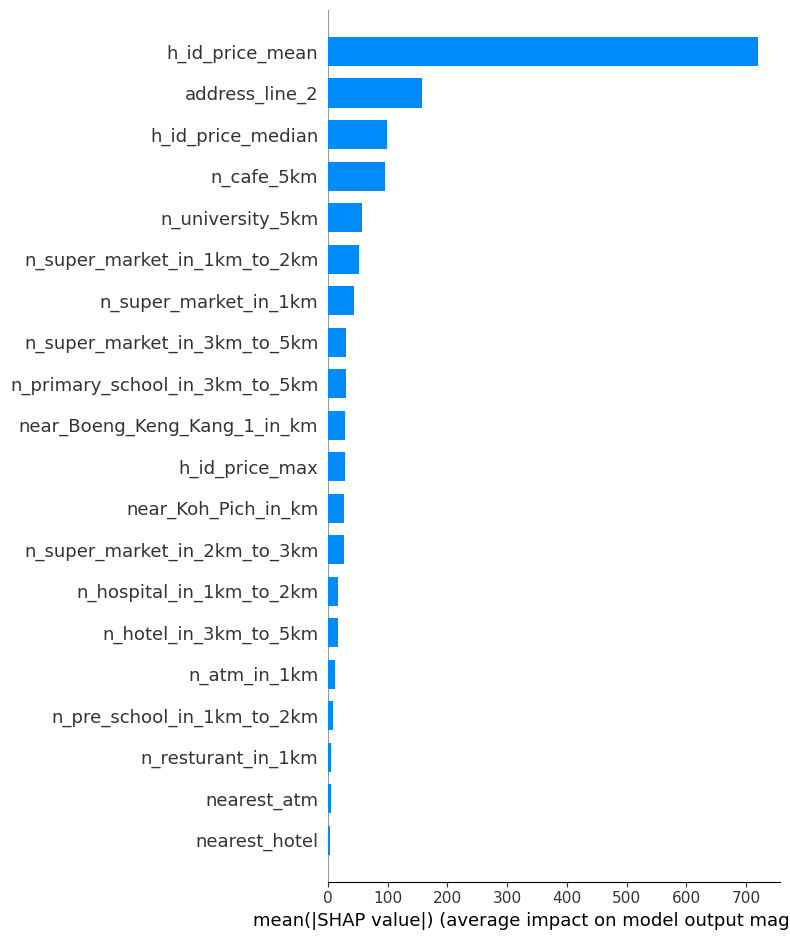

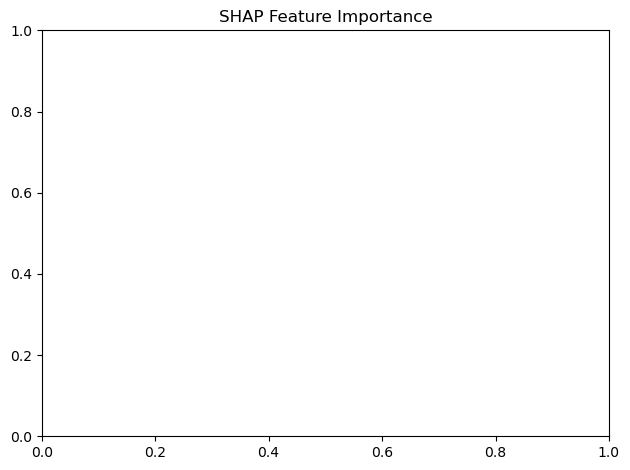

In [19]:
# SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_sel)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sel, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig("shap_importance.png")
plt.show()

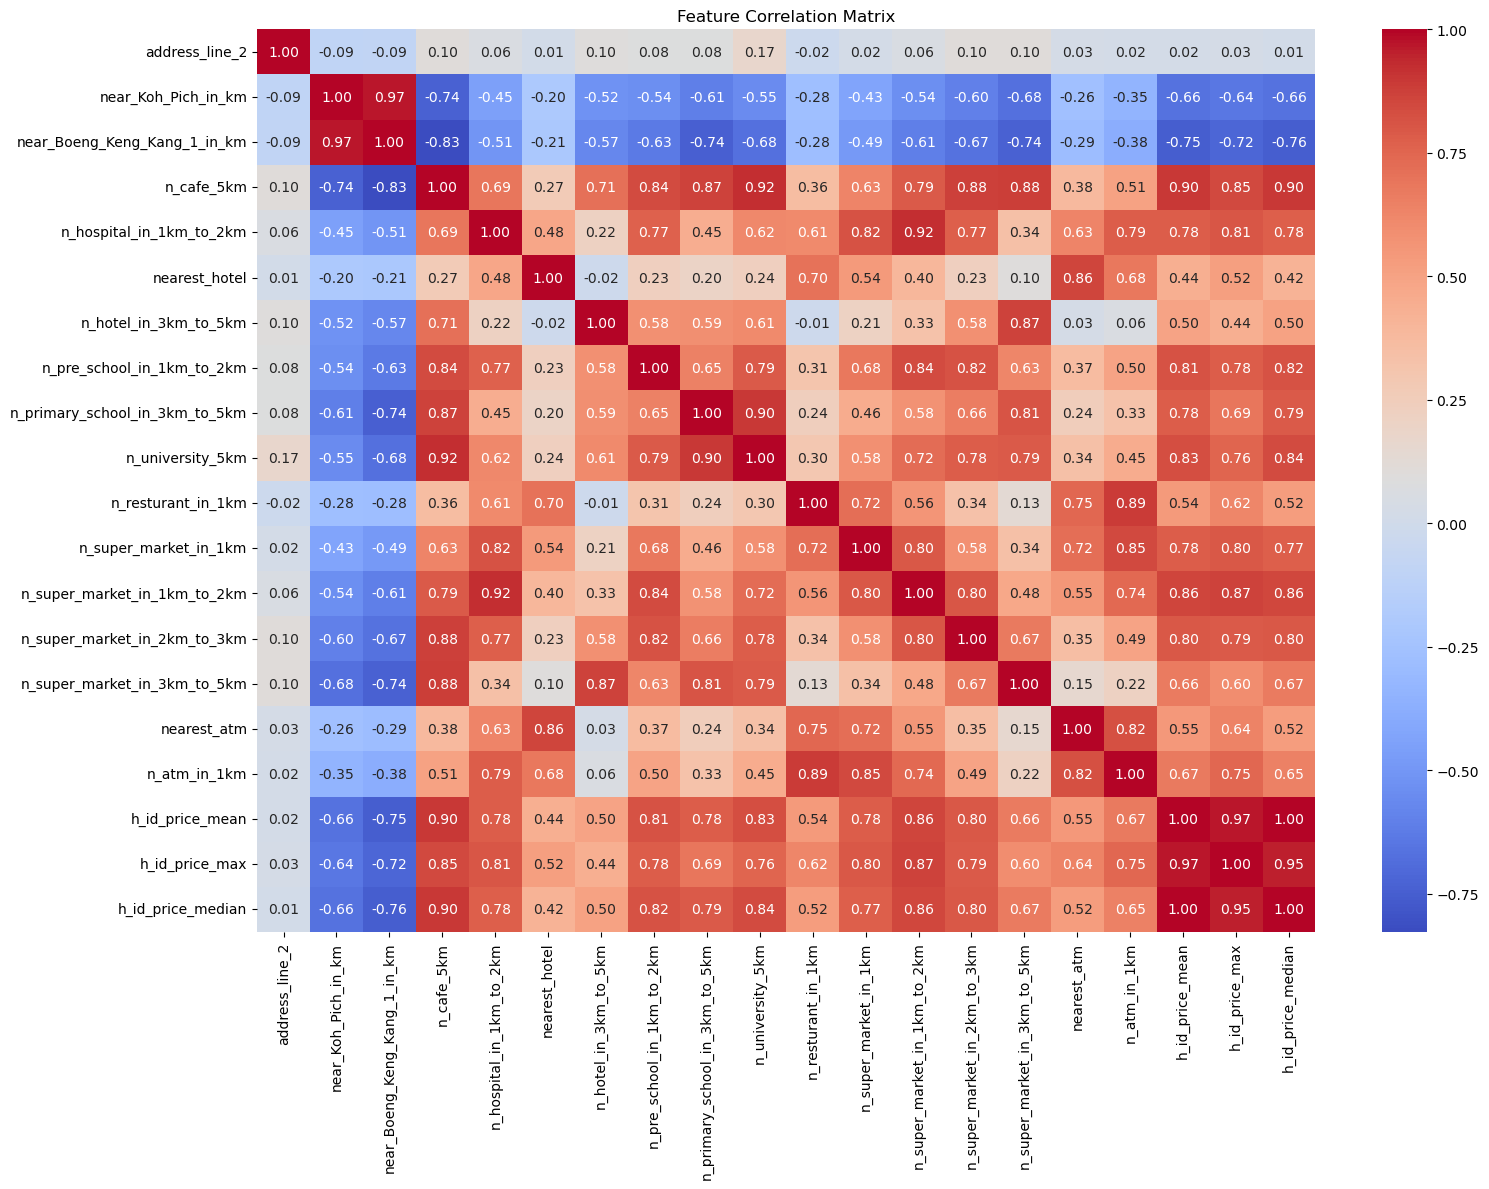

In [20]:
# 8. Feature Correlation Analysis
plt.figure(figsize=(16, 12))
corr_matrix = X_train_sel.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("feature_correlation.png")
plt.show()

In [21]:

# 9. Generate Diagnostic Report
print("\n===== MODEL DIAGNOSTICS REPORT =====")
print(f"Original features: {len(X.columns)}")
print(f"Selected features: {len(selected_features)}")
print(f"Validation R Sqare score: {study.best_value:.4f}")



===== MODEL DIAGNOSTICS REPORT =====
Original features: 219
Selected features: 20
Validation R Sqare score: 0.9809


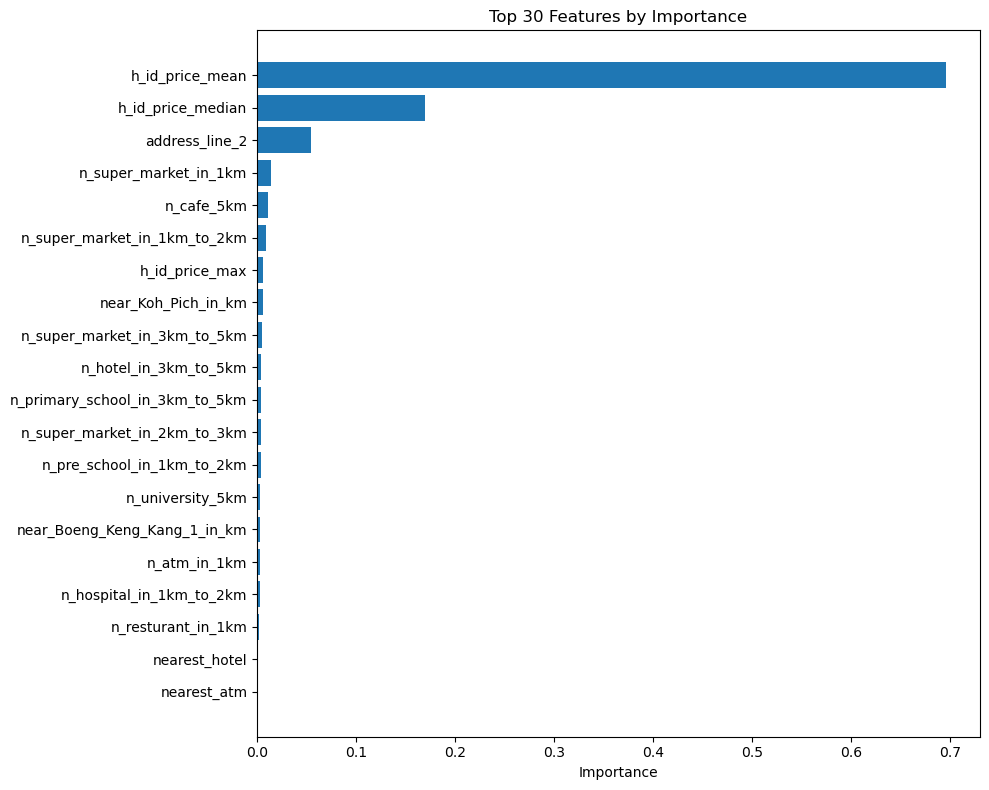

In [22]:
# Top features by importance
feature_importance = pd.DataFrame({
    'Feature': X_test_sel.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_n = 30
plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance.head(top_n)['Feature'][::-1],  # reverse for descending order
    feature_importance.head(top_n)['Importance'][::-1]
)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Features by Importance')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import OneHotEncoder

# Select only the categorical columns that are in the selected features
cat_selected = [col for col in cat_cols if col in selected_features]

# One-hot encode categorical features in X[selected_features]
if cat_selected:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(X[cat_selected])

    # Transform and create DataFrame for encoded features
    X_ohe = pd.DataFrame(
        ohe.transform(X[cat_selected]),
        index=X.index,
        columns=ohe.get_feature_names_out(cat_selected)
    )

    # Drop original categorical columns and concatenate encoded columns
    X_sel_enc = pd.concat([X[selected_features].drop(columns=cat_selected), X_ohe], axis=1)
else:
    X_sel_enc = X[selected_features].copy()

In [24]:
X_sel_enc

,near_Koh_Pich_in_km,near_Boeng_Keng_Kang_1_in_km,n_cafe_5km,n_hospital_in_1km_to_2km,nearest_hotel,n_hotel_in_3km_to_5km,n_pre_school_in_1km_to_2km,n_primary_school_in_3km_to_5km,n_university_5km,n_resturant_in_1km,...,address_line_2_Tuek Thla,address_line_2_Tumnob Tuek,address_line_2_Tuol Sangke,address_line_2_Tuol Svay Prey Ti Muoy,address_line_2_Tuol Svay Prey Ti Pir,address_line_2_Tuol Tumpung Ti Muoy,address_line_2_Tuol Tumpung Ti Pir,address_line_2_Veal Sbov,address_line_2_Veal Vong,address_line_2_Voat Phnum
0,5,6,28,0,0,2,0,6,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,172,50,5,7,14,37,88,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,3,138,5,0,48,14,39,90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,5,79,1,0,9,2,37,63,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,160,5,0,77,14,39,96,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,10,17,0,0,0,1,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,10,10,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,17,17,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,11,10,7,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_sel_enc

,near_Koh_Pich_in_km,near_Boeng_Keng_Kang_1_in_km,n_cafe_5km,n_hospital_in_1km_to_2km,nearest_hotel,n_hotel_in_3km_to_5km,n_pre_school_in_1km_to_2km,n_primary_school_in_3km_to_5km,n_university_5km,n_resturant_in_1km,...,address_line_2_Tuek Thla,address_line_2_Tumnob Tuek,address_line_2_Tuol Sangke,address_line_2_Tuol Svay Prey Ti Muoy,address_line_2_Tuol Svay Prey Ti Pir,address_line_2_Tuol Tumpung Ti Muoy,address_line_2_Tuol Tumpung Ti Pir,address_line_2_Veal Sbov,address_line_2_Veal Vong,address_line_2_Voat Phnum
0,5,6,28,0,0,2,0,6,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,172,50,5,7,14,37,88,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,3,138,5,0,48,14,39,90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,5,79,1,0,9,2,37,63,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,160,5,0,77,14,39,96,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,10,10,17,0,0,0,1,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,10,10,14,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,17,17,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,11,10,7,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
full_selected = pd.concat([X_sel_enc, y], axis=1)


In [27]:
full_selected.to_csv("../../../data/preprocessed/feature_selection_by_model_mock_data_20feature.csv", index=False)